# KAGGLE TITANIC COMPETITION


As we want to classify each passengers either as surivived(1) or not(0), it seems we have an example of logistic regression.
We have different columns on our data that might need to be transformed to fit our model.

It seems that in the name we can get some information about the title of the person(Mr, Ms, Dr, etc...). This could be useful to extract this information.


Embarked is the Port of Embarkation 	
C = Cherbourg, Q = Queenstown, S = Southampton
We can imagine that according to where you embark you have maybe different skills that we allowed you to survive or not

pclass is the Ticket class 	
1 = 1st, 2 = 2nd, 3 = 3rd

sibsp is the number of siblings / spouses aboard the Titanic

parch is the number of parents / children aboard the Titanic

I don't think in a first time that the ticket number is important as it does not give us indication where te passenger is located. In a first time i will not this feature.


In [889]:
import pandas as pd
import numpy as np
import os

os.getcwd()
Xtrain=pd.read_csv('train.csv')
ytrain=Xtrain[['PassengerId','Survived']]
ytrain=ytrain.set_index(['PassengerId'])

Xtest=pd.read_csv('test.csv')

## Analysing of some of the fields

In [888]:
Xtrain.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [667]:
Xtest.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

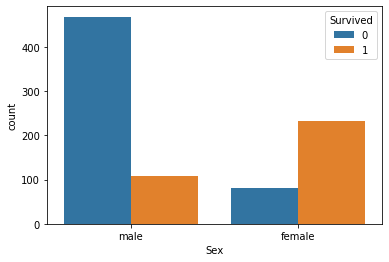

In [705]:
import seaborn as sns
import matplotlib.pyplot as plt
#Show value counts for two categorical variables
sns.countplot(x='Sex', hue='Survived', data=Xtrain)

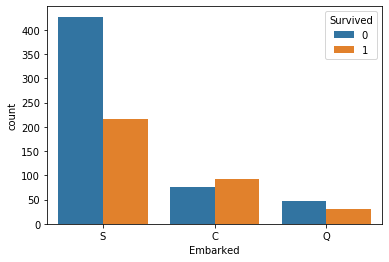

In [658]:
sns.countplot(x='Embarked', hue='Survived', data=Xtrain)


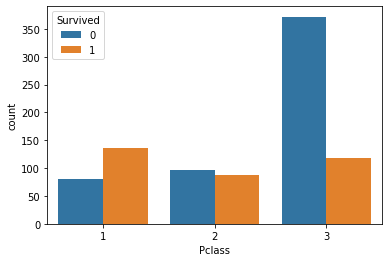

In [682]:
sns.countplot(x='Pclass', hue='Survived', data=Xtrain)


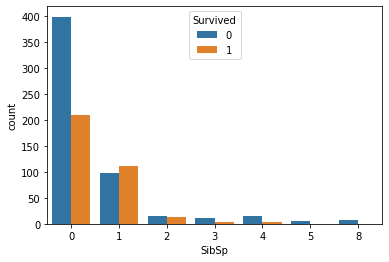

In [659]:
sns.countplot(x='SibSp', hue='Survived', data=Xtrain)

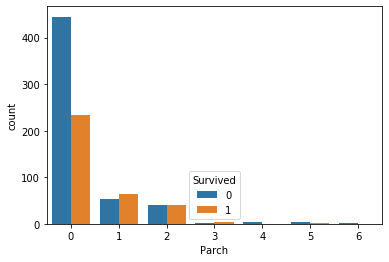

In [661]:
sns.countplot(x='Parch', hue='Survived', data=Xtrain)

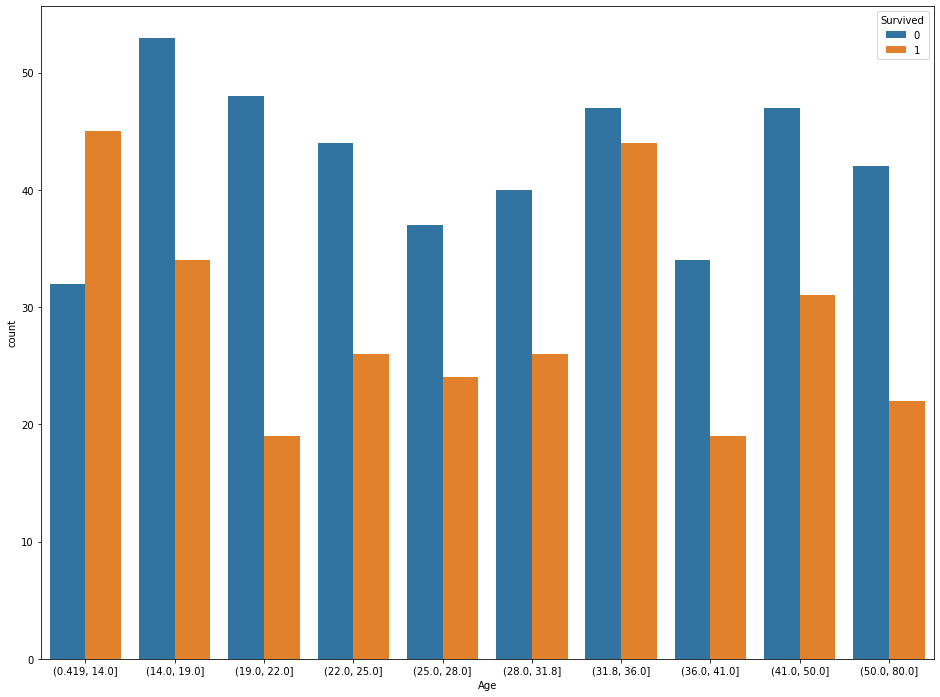

In [711]:
plt.figure(figsize=(16,12))
sns.countplot(x=pd.qcut(Xtrain['Age'],10), hue='Survived', data=Xtrain)
plt.show()

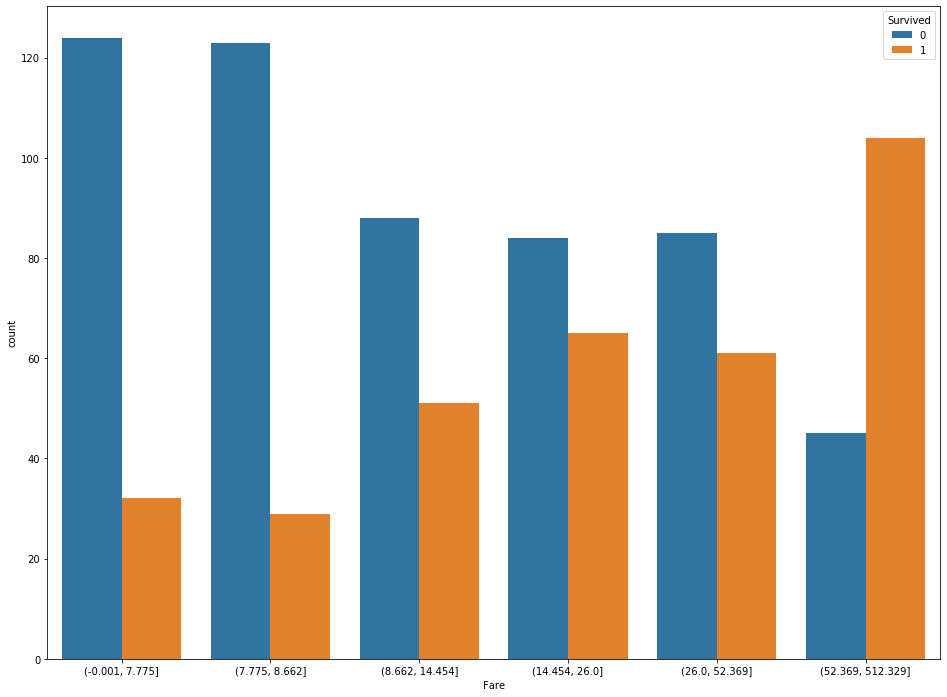

In [708]:
#Qcut cuts into bin according to the distribution
plt.figure(figsize=(16,12))
FareBins=pd.qcut(Xtrain['Fare'],6)
sns.countplot(x=pd.qcut(Xtrain['Fare'],6), hue='Survived', data=Xtrain)
plt.show()

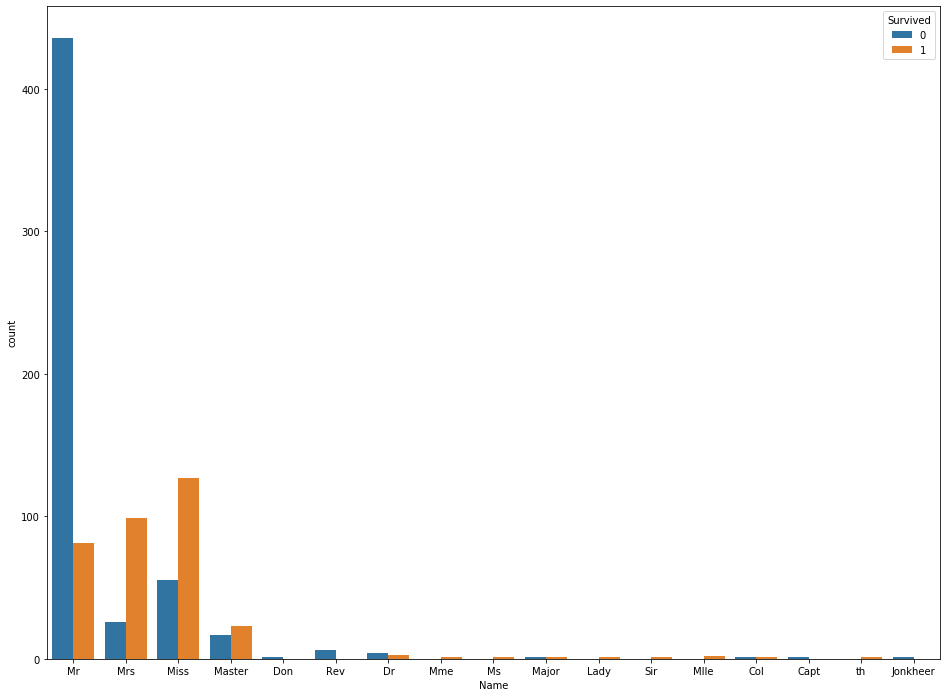

In [707]:
#Get the title from the name and fill the NA from the age according to this title
plt.figure(figsize=(16,12))
titles=Xtrain['Name'].apply(lambda x: re.split('. ',re.split(', ',x)[1])[0])
sns.countplot(x=titles, hue='Survived', data=Xtrain)
plt.show()

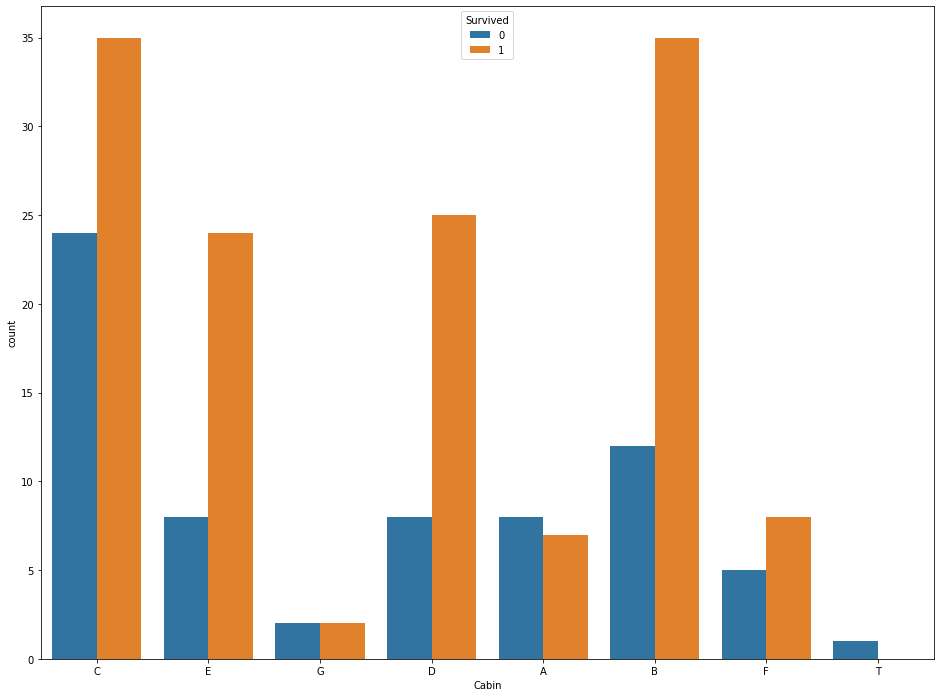

In [882]:
#Get the Cabin initial from the CAbin
plt.figure(figsize=(16,12))
CabinInitial=Xtrain['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else x)

sns.countplot(x=CabinInitial, hue='Survived', data=Xtrain)
plt.show()

In [717]:
Xtrain.iloc[:,1:].corr(method ='pearson')

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


## Get rid of the unnecessary data

In [883]:
Xtrain[Xtrain['Embarked'].isnull()==True]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


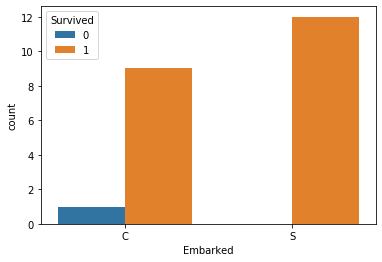

In [890]:
sns.countplot(x='Embarked', hue='Survived',data=Xtrain[(Xtrain['Pclass']==1) & (Xtrain['Fare']>=80) & (Xtrain['Cabin'].apply(lambda x: 'B' in x if pd.notnull(x) else False)==True)])

Xtrain['Embarked'].fillna('S', inplace=True)

In [891]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


def cleanData(X):

    Embarked_dummies=pd.get_dummies(X['Embarked'], drop_first=True)
    Sex_dummies=pd.get_dummies(X['Sex'], drop_first=True)
    Pclass_dummies=pd.get_dummies(X['Pclass'], drop_first=True)
    X=pd.concat([X, Embarked_dummies], axis=1)
    X=pd.concat([X, Sex_dummies], axis=1)
    X=pd.concat([X, Pclass_dummies], axis=1)
    X.drop(['Sex','Embarked','Pclass'], axis=1, inplace=True)
    
    X['Fare']=X['Fare'].fillna(X['Fare'].mean())

    
    #Get the title from the name and fill the NA for the age, according to the title of the person
    X['Title']=X['Name'].apply(lambda x: re.split('. ',re.split(', ',x)[1])[0])
    
    Title_grouped=pd.DataFrame(X.groupby(['Title'])['Age'].median())
    Title_grouped.rename(columns={'Age':'Mean_Age'}, inplace=True)
    Title_grouped=Title_grouped.reset_index()
    X=pd.merge(X,Title_grouped, on='Title')
    X['Age']=X['Age'].fillna(X['Mean_Age'])
    X['Age']=X['Age'].fillna(X['Age'].median())
    
    
    #Title_dummies=pd.get_dummies(X['Title'], drop_first=True)
    #X=pd.concat([X, Title_dummies], axis=1)
    label_encoder = LabelEncoder()
    X['TitleEncoded'] = label_encoder.fit_transform(X['Title'])
    
    #X['CabinBool']=X['Cabin'].isna()==False
    
    X.drop(['Ticket','Name','Cabin','Mean_Age','Title'], axis=1, inplace=True)
    
    #drop the survived column
    if 'Survived' in X.columns: X.drop(['Survived'], axis=1, inplace=True)
    X.set_index('PassengerId',inplace=True)
    X=X.sort_values(by='PassengerId',axis=0)
    return X

def normalizingData(X):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    '''X['Age']=(X['Age']-X['Age'].min())/(X['Age'].max()-X['Age'].min())
    X['Fare']=(X['Fare']-X['Fare'].min())/(X['Fare'].max()-X['Fare'].min())
    X['TitleEncoded']=(X['TitleEncoded']-X['TitleEncoded'].min())/(X['TitleEncoded'].max()-X['TitleEncoded'].min())
    X['SibSp']=(X['SibSp']-X['SibSp'].min())/(X['SibSp'].max()-X['SibSp'].min())
    X['Parch']=(X['Parch']-X['Parch'].min())/(X['Parch'].max()-X['Parch'].min())'''
    return X
    
    
    


## Normalizing our data using the max/min and get dummies for the string


In [892]:
#drop_first=True Whether to get k-1 dummies out of k categorical levels by removing the first level.

Xtrain=cleanData(Xtrain)
Xtest=cleanData(Xtest)
Xtest

,Age,SibSp,Parch,Fare,Q,S,male,2,3,TitleEncoded
PassengerId,,,,,,,,,,
892,34.5,0,0,7.8292,1,0,1,0,1,5
893,47.0,1,0,7.0000,0,1,0,0,1,6
894,62.0,0,0,9.6875,1,0,1,1,0,5
895,27.0,0,0,8.6625,0,1,1,0,1,5
896,22.0,1,1,12.2875,0,1,0,0,1,6
...,...,...,...,...,...,...,...,...,...,...
1305,28.5,0,0,8.0500,0,1,1,0,1,5
1306,39.0,0,0,108.9000,0,0,0,0,0,1
1307,38.5,0,0,7.2500,0,1,1,0,1,5


In [893]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=0)

In [894]:
Xtrain

,Age,SibSp,Parch,Fare,Q,S,male,2,3,TitleEncoded
PassengerId,,,,,,,,,,
1,22.0,1,0,7.2500,0,1,1,0,1,11
2,38.0,1,0,71.2833,0,0,0,0,0,12
3,26.0,0,0,7.9250,0,1,0,0,1,8
4,35.0,1,0,53.1000,0,1,0,0,0,12
5,35.0,0,0,8.0500,0,1,1,0,1,11
...,...,...,...,...,...,...,...,...,...,...
887,27.0,0,0,13.0000,0,1,1,1,0,14
888,19.0,0,0,30.0000,0,1,0,0,0,8
889,21.0,1,2,23.4500,0,1,0,0,1,8


In [895]:
from sklearn.linear_model import LogisticRegression
X_train=normalizingData(X_train)
X_test=normalizingData(X_test)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print('Score Train: '+str(clf.score(X_train, y_train)))
print('Score Test: '+str(clf.score(X_test, y_test)))



Score Train: 0.8061797752808989
Score Test: 0.8044692737430168


C:\Users\jc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jc\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [896]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       110
           1       0.77      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [897]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,11,1))}
]

# Create grid search object

clfgrid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clfgrid.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   24.6s finished
C:\Users\jc\Anaconda3\lib\site-packages\sklearn\pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [898]:
print('Score Train: '+str(best_clf.score(X_train, y_train)))
print('Score Test: '+str(best_clf.score(X_test, y_test)))

Score Train: 0.9648876404494382
Score Test: 0.7821229050279329


In [842]:
prediction=best_clf.predict(Xtest)


In [843]:
yfinal=pd.DataFrame()
yfinal['PassengerId']=Xtest.index
yfinal['Survived']=prediction
yfinal.to_csv('Results.csv')

prediction2=clf.predict(X_test)
yfinal1=pd.DataFrame()
yfinal1['PassengerId']=X_test.index
yfinal1['Survived']=prediction2
yfinal1['SurvivedReal']=y_test.reset_index()['Survived']
Xgrouped=pd.read_csv('train.csv')
Xgrouped=pd.merge(Xgrouped,yfinal, on='PassengerId')
Xgrouped.to_csv('comparison.csv')



AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [844]:
clf.coef_

array([[-0.52297231, -0.4731451 , -0.04198122,  0.10237396, -0.01447577,
        -0.14105965, -1.22480189, -0.33474637, -1.00078423, -0.17622584]])

## Conclusion
After cleaning the data and creating some new features we could estimate the people that survived for the titanic with an accuracy of 80%.